In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('used_car_clean.csv')

print(f" Đã load {len(df)} dòng dữ liệu")
print("\n Cột trong dataset:")
print(df.columns.tolist())

 Đã load 8510 dòng dữ liệu

 Cột trong dataset:
['Age', 'AskPrice', 'Brand_std', 'Fuel_std', 'Owner_std', 'Transmission_std', 'Year', 'kmDriven', 'km_per_year']


In [3]:
# ============================================
# 2. CHỌN ĐẶC TRƯNG VÀ TARGET
# ============================================
# Điều chỉnh các cột feature theo dataset thực tế của cậu
# Ví dụ dưới đây giả sử có các cột: Year, Kilometer, Age, FuelType, Transmission, Brand

# Các cột số (numeric) - dùng tên cột thực tế trong `used_car_clean.csv`
# Trong dataset này các cột tương ứng là: Year, kmDriven, Age
numeric_features = ['Year', 'kmDriven', 'Age']  # Thay tên cột cho đúng

# Các cột phân loại (categorical) - cần encode (dùng tên thực tế)
# Dataset chứa các cột: Brand_std, Fuel_std, Owner_std, Transmission_std
categorical_features = ['Fuel_std', 'Transmission_std', 'Brand_std', 'Owner_std']  # Thay tên cột cho đúng

# Target: giá xe
target = 'AskPrice'  # Thay tên cột cho đúng

# Xử lý missing values
df = df.dropna(subset=[target])

# One-hot encoding cho categorical features
df_encoded = pd.get_dummies(df[numeric_features + categorical_features], drop_first=True)

# Tách X và y
X = df_encoded
y = df[target]

print(f"\n Số lượng features: {X.shape[1]}")
print(f" Số lượng samples: {X.shape[0]}")



 Số lượng features: 40
 Số lượng samples: 8510


In [4]:
# ============================================
# 3. CHIA TẬP TRAIN/TEST
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n Train set: {len(X_train)} samples")
print(f" Test set: {len(X_test)} samples")



 Train set: 6808 samples
 Test set: 1702 samples


In [5]:
# ============================================
# 4. TRAIN 5 MÔ HÌNH HỒI QUY
# ============================================
print("\n Đang train 5 mô hình...")

models = {}
predictions = {}
results = []

# 4.1 Linear Regression
print("  → Linear Regression...")
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
models['Linear'] = lr
predictions['Linear'] = lr.predict(X_test_scaled)

# 4.2 Polynomial Regression (degree=2)
print("  → Polynomial Regression...")
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
pr = LinearRegression()
pr.fit(X_train_poly, y_train)
models['Polynomial'] = pr
predictions['Polynomial'] = pr.predict(X_test_poly)

# 4.3 Ridge Regression
print("  → Ridge Regression...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
models['Ridge'] = ridge
predictions['Ridge'] = ridge.predict(X_test_scaled)

# 4.4 Lasso Regression
print("  → Lasso Regression...")
lasso = Lasso(alpha=1.0, random_state=42)
lasso.fit(X_train_scaled, y_train)
models['Lasso'] = lasso
predictions['Lasso'] = lasso.predict(X_test_scaled)

# 4.5 ElasticNet Regression
print("  → ElasticNet Regression...")
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic.fit(X_train_scaled, y_train)
models['ElasticNet'] = elastic
predictions['ElasticNet'] = elastic.predict(X_test_scaled)



 Đang train 5 mô hình...
  → Linear Regression...
  → Polynomial Regression...
  → Ridge Regression...
  → Lasso Regression...
  → ElasticNet Regression...


In [6]:
# ============================================
# 5. ĐÁNH GIÁ CÁC MÔ HÌNH
# ============================================
print("\n Đang tính toán metrics...")

for name, y_pred in predictions.items():
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # Tính % sai số tương đối trung bình
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    # Tính % dự đoán trong khoảng sai số cho phép (±20% giá thực tế)
    within_20_percent = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.2) * 100
    
    results.append({
        'Model': name,
        'R²': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2),
        'MAPE (%)': round(mape, 2),
        'Within ±20%': round(within_20_percent, 2)
    })

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results)

# Chuẩn hóa và tính điểm tổng hợp
min_max_cols = ['RMSE', 'MAE', 'MAPE (%)']
for col in min_max_cols:
    min_val = results_df[col].min()
    max_val = results_df[col].max()
    results_df[f'{col}_score'] = (max_val - results_df[col]) / (max_val - min_val)

results_df['Overall_Score'] = (
    results_df['R²'] * 0.3 +  # R² chiếm 30%
    results_df['RMSE_score'] * 0.2 +  # RMSE chiếm 20%
    results_df['MAE_score'] * 0.2 +  # MAE chiếm 20%
    results_df['MAPE (%)_score'] * 0.2 +  # MAPE chiếm 20%
    results_df['Within ±20%'] / 100 * 0.1  # % dự đoán chính xác chiếm 10%
)

# Sắp xếp theo điểm tổng hợp
results_df = results_df.sort_values('Overall_Score', ascending=False)

# In kết quả
print("\n" + "="*100)
print(" BẢNG KẾT QUẢ SO SÁNH CÁC MÔ HÌNH")
print("="*100)
print("Các metrics càng thấp càng tốt, ngoại trừ R² và Within ±20% càng cao càng tốt")
display_cols = ['Model', 'R²', 'RMSE', 'MAE', 'MAPE (%)', 'Within ±20%', 'Overall_Score']
print(results_df[display_cols].to_string(index=False))
print("="*100)

# Tìm mô hình tốt nhất
best_model = results_df.iloc[0]['Model']
best_score = results_df.iloc[0]['Overall_Score']
print(f"\n Mô hình tốt nhất: {best_model} (Overall Score: {best_score:.4f})")

# Phân tích chi tiết mô hình tốt nhất
best_metrics = results_df.iloc[0]
print("\n Chi tiết mô hình tốt nhất:")
print(f"• R² = {best_metrics['R²']:.4f} (giải thích được {best_metrics['R²']*100:.1f}% biến động của giá)")
print(f"• RMSE = {best_metrics['RMSE']:,.0f} (sai số trung bình bình phương)")
print(f"• MAE = {best_metrics['MAE']:,.0f} (sai số tuyệt đối trung bình)")
print(f"• MAPE = {best_metrics['MAPE (%)']:.2f}% (% sai số trung bình)")
print(f"• {best_metrics['Within ±20%']:.1f}% dự đoán nằm trong khoảng ±20% giá thực tế")


 Đang tính toán metrics...

 BẢNG KẾT QUẢ SO SÁNH CÁC MÔ HÌNH
Các metrics càng thấp càng tốt, ngoại trừ R² và Within ±20% càng cao càng tốt
     Model     R²      RMSE       MAE  MAPE (%)  Within ±20%  Overall_Score
Polynomial 0.6758 607973.06 291978.45     38.37        42.71       0.845450
     Lasso 0.5935 680795.87 391341.93     63.36        31.49       0.271152
     Ridge 0.5935 680822.20 391360.78     63.37        31.49       0.270984
    Linear 0.5934 680873.39 391411.61     63.40        31.49       0.270515
ElasticNet 0.5548 712431.43 391702.03     57.13        29.85       0.246390

 Mô hình tốt nhất: Polynomial (Overall Score: 0.8455)

 Chi tiết mô hình tốt nhất:
• R² = 0.6758 (giải thích được 67.6% biến động của giá)
• RMSE = 607,973 (sai số trung bình bình phương)
• MAE = 291,978 (sai số tuyệt đối trung bình)
• MAPE = 38.37% (% sai số trung bình)
• 42.7% dự đoán nằm trong khoảng ±20% giá thực tế



 Đang tạo biểu đồ...
 Đã lưu: r2_comparison.png


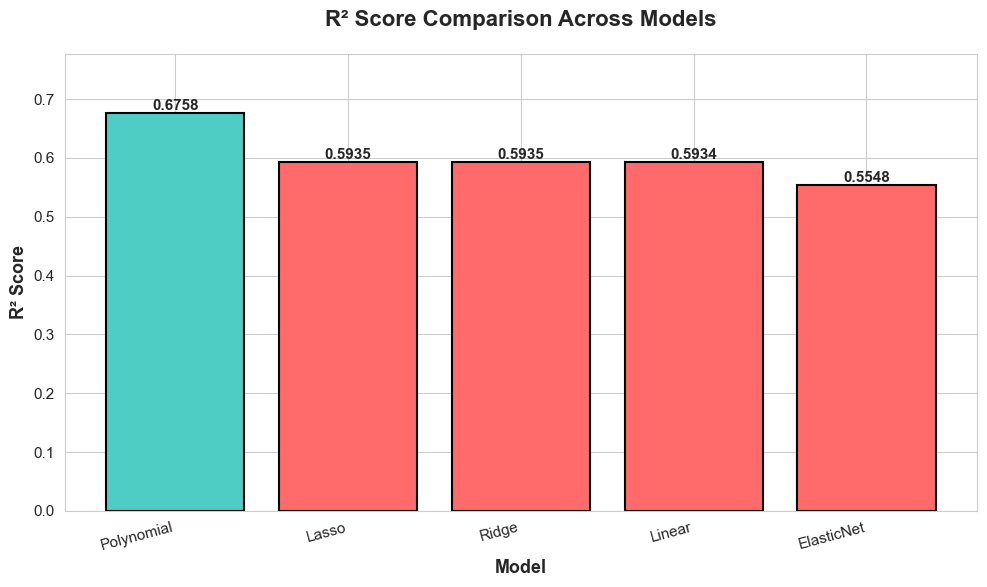

 Đã lưu: actual_vs_predicted.png


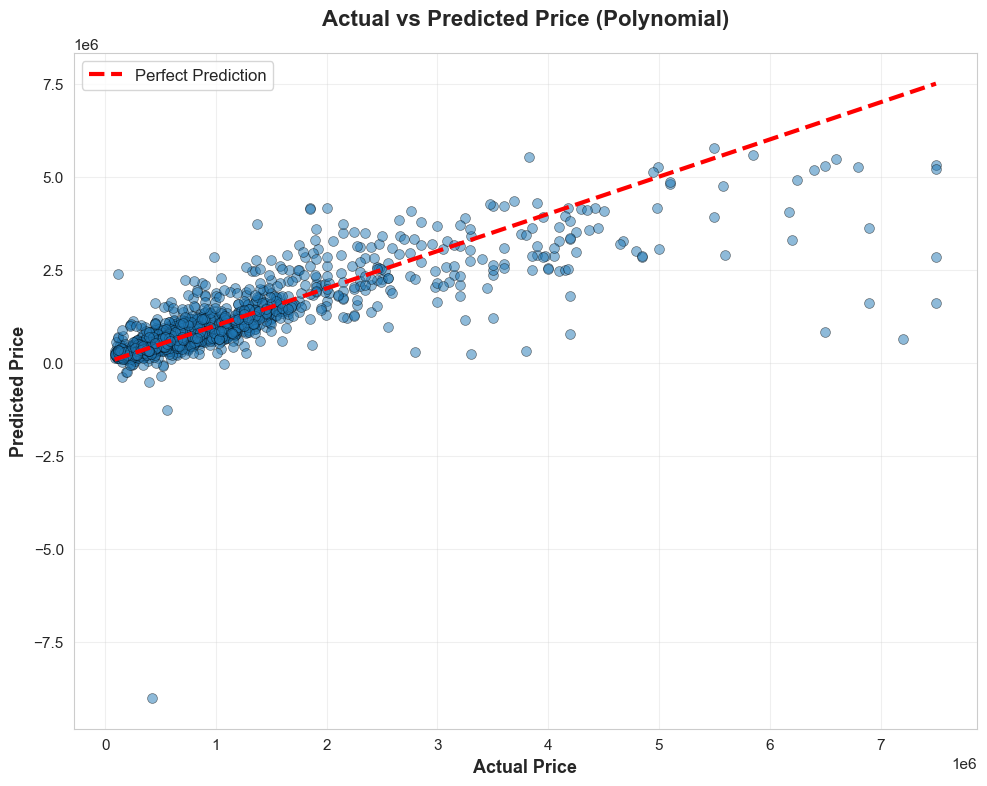

 Đã lưu: error_metrics_comparison.png


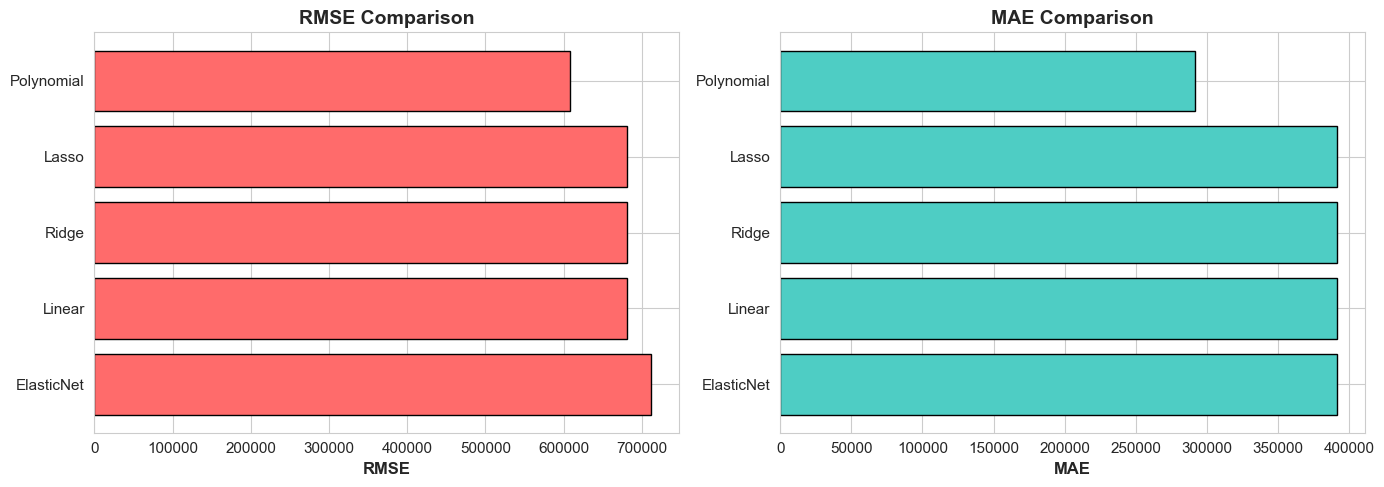

 Đã lưu: overall_score_comparison.png


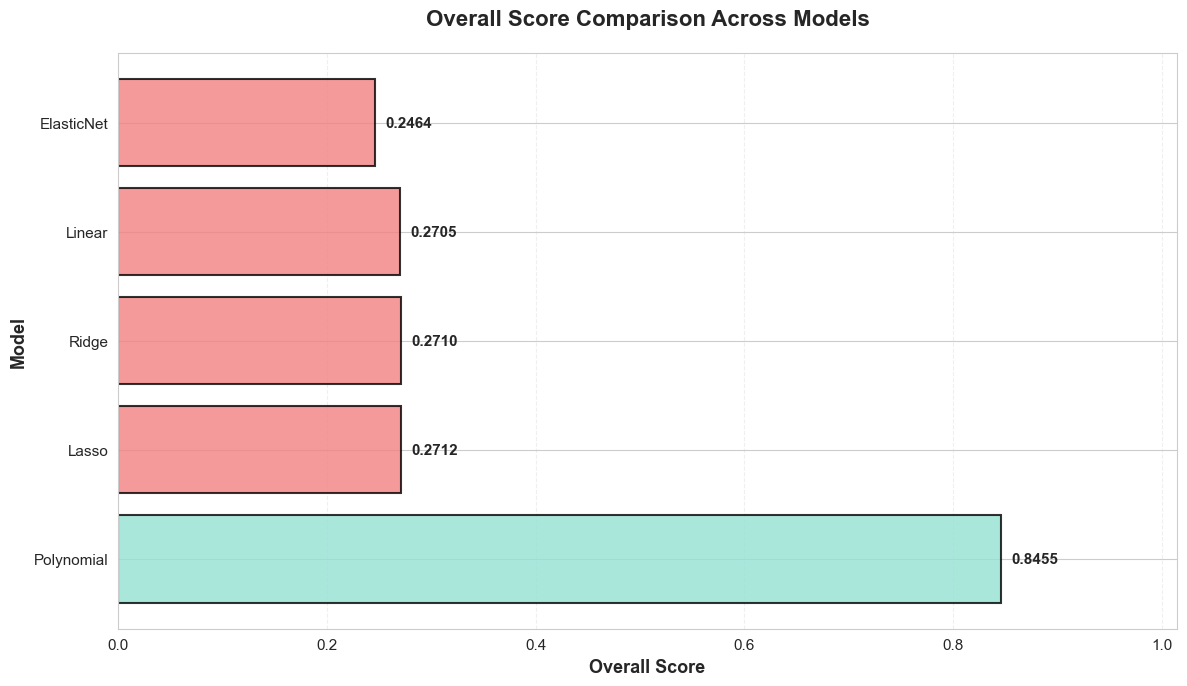

In [7]:
# ============================================
# 6. VISUALIZATION
# ============================================
print("\n Đang tạo biểu đồ...")

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 11

# 6.1 Biểu đồ so sánh R²
plt.figure(figsize=(10, 6))
colors = ['#FF6B6B' if x != best_model else '#4ECDC4' for x in results_df['Model']]
bars = plt.bar(results_df['Model'], results_df['R²'], color=colors, edgecolor='black', linewidth=1.5)

# Thêm giá trị lên đầu cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('R² Score Comparison Across Models', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=13, fontweight='bold')
plt.ylabel('R² Score', fontsize=13, fontweight='bold')
plt.ylim(0, max(results_df['R²']) * 1.15)
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('r2_comparison.png', dpi=300, bbox_inches='tight')
print(" Đã lưu: r2_comparison.png")
plt.show()

# 6.2 Biểu đồ Actual vs Predicted (mô hình tốt nhất)
plt.figure(figsize=(10, 8))
y_pred_best = predictions[best_model]

plt.scatter(y_test, y_pred_best, alpha=0.5, s=50, edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect Prediction')

plt.title(f'Actual vs Predicted Price ({best_model})', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Actual Price', fontsize=13, fontweight='bold')
plt.ylabel('Predicted Price', fontsize=13, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=300, bbox_inches='tight')
print(" Đã lưu: actual_vs_predicted.png")
plt.show()

# 6.3 Biểu đồ so sánh RMSE và MAE
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE
axes[0].barh(results_df['Model'], results_df['RMSE'], color='#FF6B6B', edgecolor='black')
axes[0].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[0].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# MAE
axes[1].barh(results_df['Model'], results_df['MAE'], color='#4ECDC4', edgecolor='black')
axes[1].set_xlabel('MAE', fontsize=12, fontweight='bold')
axes[1].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('error_metrics_comparison.png', dpi=300, bbox_inches='tight')
print(" Đã lưu: error_metrics_comparison.png")
plt.show()

# 6.4 Biểu đồ Overall Score Comparison
plt.figure(figsize=(12, 7))
colors = ['#95E1D3' if x == best_model else '#F38181' for x in results_df['Model']]
bars = plt.barh(results_df['Model'], results_df['Overall_Score'], color=colors, 
                edgecolor='black', linewidth=1.5, alpha=0.8)

# Thêm giá trị lên đầu cột
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
             f'{width:.4f}',
             ha='left', va='center', fontweight='bold', fontsize=11)

plt.title('Overall Score Comparison Across Models', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Overall Score', fontsize=13, fontweight='bold')
plt.ylabel('Model', fontsize=13, fontweight='bold')
plt.xlim(0, max(results_df['Overall_Score']) * 1.2)
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('overall_score_comparison.png', dpi=300, bbox_inches='tight')
print(" Đã lưu: overall_score_comparison.png")
plt.show()

In [8]:
# ============================================
# 7. EXPORT KẾT QUẢ
# ============================================
results_df.to_csv('regression_results.csv', index=False)
print("\n Đã lưu kết quả: regression_results.csv")

print("\n" + "="*60)
print(" HOÀN THÀNH!")
print("="*60)
print(" Files đã tạo:")
print("  - r2_comparison.png")
print("  - actual_vs_predicted.png")
print("  - error_metrics_comparison.png")
print("  - overall_score_comparison.png")
print("  - regression_results.csv")
print("="*60)


 Đã lưu kết quả: regression_results.csv

 HOÀN THÀNH!
 Files đã tạo:
  - r2_comparison.png
  - actual_vs_predicted.png
  - error_metrics_comparison.png
  - overall_score_comparison.png
  - regression_results.csv


In [9]:
print("\n Thống kê về giá xe (AskPrice):")
print(df['AskPrice'].describe())

print("\n Phân vị của giá xe:")
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
for p in percentiles:
    print(f"{int(p*100)}th percentile: {df['AskPrice'].quantile(p):,.0f}")


 Thống kê về giá xe (AskPrice):
count    8.510000e+03
mean     9.348521e+05
std      1.025658e+06
min      8.000000e+04
25%      3.600000e+05
50%      5.900000e+05
75%      1.060000e+06
max      7.500000e+06
Name: AskPrice, dtype: float64

 Phân vị của giá xe:
25th percentile: 360,000
50th percentile: 590,000
75th percentile: 1,060,000
90th percentile: 1,990,000
95th percentile: 3,000,000
99th percentile: 5,500,000
